In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

from spine_vision.io import read_medical_image, normalize_to_uint8
from spine_vision.datasets.classification import (
    extract_middle_slice,
    resample_to_isotropic,
    load_localization_model,
    predict_ivd_locations,
    get_slice_spacing,
    mm_to_pixels,
    get_rotation_angles,
    CropContext,
)
from loguru import logger

/home/nghiant/Github/spine-vision/.venv/lib/python3.11/site-packages/gdown/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
logger.remove()

In [3]:
DEVICE = "cuda"
MODEL_PATH = Path.cwd().parent / "weights/localization/regression_convnext_baseline/best_model.pt"

# Choose an image to test
IMAGE_PATH = Path.cwd().parent / "data/interim/Phenikaa/images/250002076/SAG T2"

# Crop parameters
CROP_SIZE = (128, 128)
CROP_DELTA_MM = (35.0, 5.0, 20.0, 20.0)  # left, right, top, bottom in mm
IMAGE_SIZE = (512, 512)  # Model input size

## Load Image and Model

In [4]:
# Load and preprocess image
image = read_medical_image(IMAGE_PATH)
image = resample_to_isotropic(image, new_spacing=(0.3, 0.3, 0.3))
middle_slice = extract_middle_slice(image)
spacing_2d = get_slice_spacing(image)

print(f"Image shape: {middle_slice.shape}")
print(f"Spacing (row, col): {spacing_2d} mm/pixel")

Image shape: (1040, 1040)
Spacing (row, col): (0.3, 0.3) mm/pixel


In [5]:
# Load model and predict IVD locations
model = load_localization_model(MODEL_PATH, variant="base", device=DEVICE)
ivd_locations = predict_ivd_locations(model, middle_slice, device=DEVICE, image_size=IMAGE_SIZE)

print("Predicted IVD locations (normalized coordinates):")
for level_idx, (x, y) in ivd_locations.items():
    print(f"  L{level_idx + 1}/L{level_idx + 2}: ({x:.4f}, {y:.4f})")

Predicted IVD locations (normalized coordinates):
  L1/L2: (0.5044, 0.2831)
  L2/L3: (0.4921, 0.3832)
  L3/L4: (0.4695, 0.4848)
  L4/L5: (0.4594, 0.5828)
  L5/L6: (0.4702, 0.6662)


## Compute Rotation Angles

In [6]:
# Compute rotation angles (uses quadratic extrapolation for L5-S1)
rotation_angles = get_rotation_angles(ivd_locations, middle_slice.shape[:2], last_disc_angle_boost=2)

print("Rotation angles (degrees) - Quadratic extrapolation for L5-S1:")
for level_idx, angle in rotation_angles.items():
    method = "quadratic" if level_idx == 4 else "finite diff"
    print(f"  L{level_idx + 1}/L{level_idx + 2}: {angle:>7.2f}° ({method})")

Rotation angles (degrees) - Quadratic extrapolation for L5-S1:
  L1/L2:    6.98° (finite diff)
  L2/L3:    9.81° (finite diff)
  L3/L4:    9.31° (finite diff)
  L4/L5:   -0.23° (finite diff)
  L5/L6:  -26.68° (quadratic)


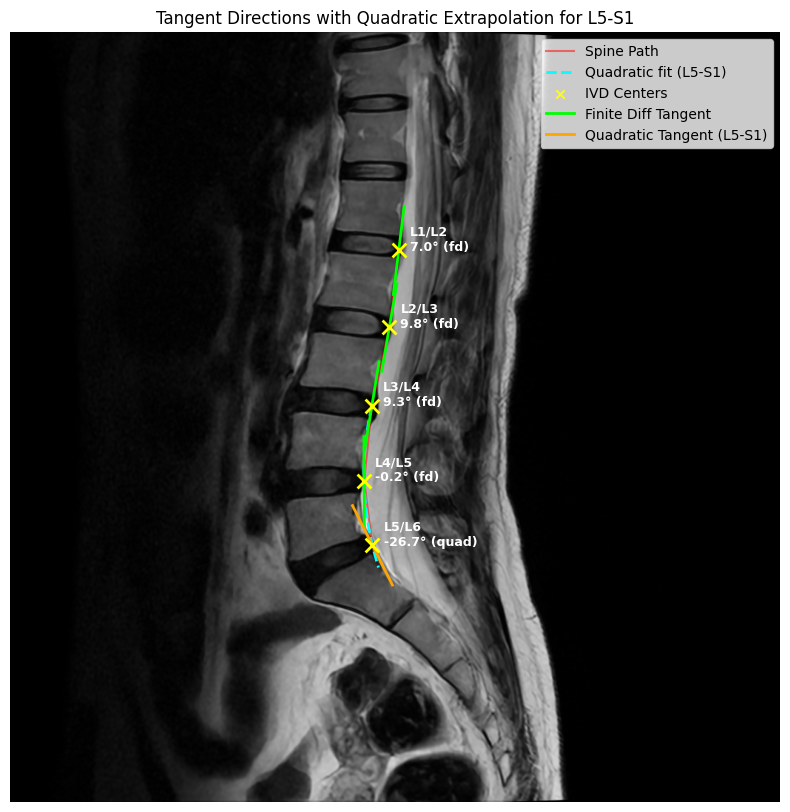

In [7]:
# Visualize the tangent directions and quadratic fit for bottom disc
h, w = middle_slice.shape[:2]

# Convert to pixel coordinates
points = [(ivd_locations[i][0] * w, ivd_locations[i][1] * h) for i in sorted(ivd_locations.keys())]
x_coords = [p[0] for p in points]
y_coords = [p[1] for p in points]

# Plot
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(normalize_to_uint8(middle_slice), cmap='gray')

# Draw connecting lines between consecutive points
ax.plot(x_coords, y_coords, 'r-', linewidth=1.5, alpha=0.5, label='Spine Path')

# Draw quadratic fit through last 3 points (for L5-S1 extrapolation)
last_3_y = np.array(y_coords[-3:])
last_3_x = np.array(x_coords[-3:])
coeffs = np.polyfit(last_3_y, last_3_x, deg=2)
y_fit = np.linspace(last_3_y[0], last_3_y[-1] + 30, 50)
x_fit = np.polyval(coeffs, y_fit)
ax.plot(x_fit, y_fit, 'cyan', linewidth=2, linestyle='--', label='Quadratic fit (L5-S1)')

# Draw points and tangent lines
tangent_length = 60
for i, (x, y) in enumerate(points):
    angle_deg = -rotation_angles[i]
    angle_rad = np.radians(angle_deg)
    
    dx = np.sin(angle_rad) * tangent_length
    dy = np.cos(angle_rad) * tangent_length
    
    color = 'lime' if i < 4 else 'orange'  # Highlight L5-S1
    ax.plot([x - dx, x + dx], [y - dy, y + dy], color, linewidth=2)
    ax.scatter([x], [y], c='yellow', s=100, marker='x', linewidth=2, zorder=5)
    
    method = "quad" if i == 4 else "fd"
    ax.annotate(f'L{i+1}/L{i+2}\n{rotation_angles[i]:.1f}° ({method})', (x + 15, y), 
                color='white', fontsize=9, fontweight='bold')

ax.scatter([], [], c='yellow', marker='x', label='IVD Centers')
ax.plot([], [], 'lime', linewidth=2, label='Finite Diff Tangent')
ax.plot([], [], 'orange', linewidth=2, label='Quadratic Tangent (L5-S1)')
ax.set_title('Tangent Directions with Quadratic Extrapolation for L5-S1')
ax.legend(loc='upper right')
ax.axis('off')
plt.tight_layout()
plt.show()

## Compare Horizontal vs Spline-Aligned Crops

In [8]:
# Convert crop deltas to pixels
crop_delta_px = mm_to_pixels(CROP_DELTA_MM, spacing_2d)
print(f"Crop deltas (pixels): left={crop_delta_px[0]}, right={crop_delta_px[1]}, top={crop_delta_px[2]}, bottom={crop_delta_px[3]}")

# Create crop contexts for both modes
ctx_horizontal = CropContext(
    image=middle_slice,
    ivd_locations=ivd_locations,
    crop_size=CROP_SIZE,
    crop_delta_px=crop_delta_px,
    mode="horizontal",
)

ctx_rotated = CropContext(
    image=middle_slice,
    ivd_locations=ivd_locations,
    crop_size=CROP_SIZE,
    crop_delta_px=crop_delta_px,
    mode="rotated",
    last_disc_angle_boost=2.0,
)

Crop deltas (pixels): left=117, right=17, top=67, bottom=67


In [9]:
# Generate crops for all levels using both modes
crops_horizontal = {}
crops_rotated = {}

for level_idx in range(5):
    crops_horizontal[level_idx] = ctx_horizontal.crop(level_idx)
    crops_rotated[level_idx] = ctx_rotated.crop(level_idx)

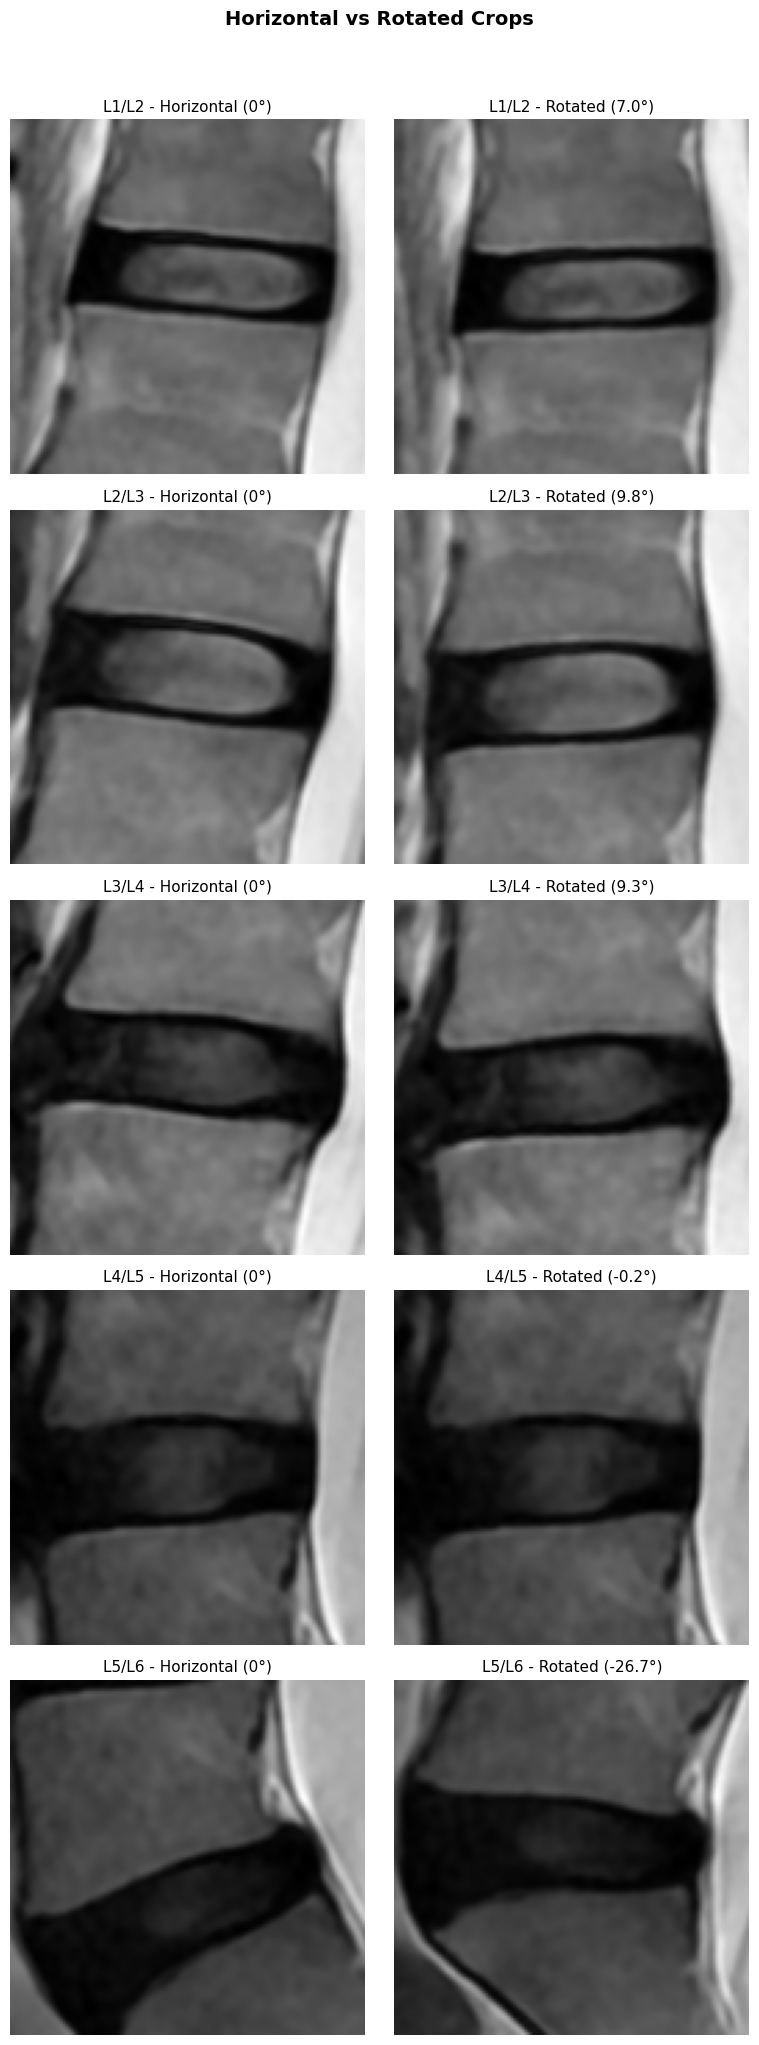

In [10]:
# Side-by-side comparison: Horizontal vs Rotated
fig, axes = plt.subplots(5, 2, figsize=(8, 20))
fig.suptitle('Horizontal vs Rotated Crops', fontsize=14, fontweight='bold', y=1.02)

for level_idx in range(5):
    level_name = f'L{level_idx + 1}/L{level_idx + 2}'
    angle = ctx_rotated.rotation_angles.get(level_idx, 0) if ctx_rotated.rotation_angles else 0
    
    # Horizontal crop (no rotation)
    ax_h = axes[level_idx, 0]
    if crops_horizontal[level_idx] is not None:
        ax_h.imshow(crops_horizontal[level_idx], cmap='gray')
    ax_h.set_title(f'{level_name} - Horizontal (0°)', fontsize=11)
    ax_h.axis('off')
    
    # Rotated crop (with rotation)
    ax_s = axes[level_idx, 1]
    if crops_rotated[level_idx] is not None:
        ax_s.imshow(crops_rotated[level_idx], cmap='gray')
    ax_s.set_title(f'{level_name} - Rotated ({angle:.1f}°)', fontsize=11)
    ax_s.axis('off')

plt.tight_layout()
plt.show()

## Visualize Crop Regions on Original Image

In [11]:
import cv2

def draw_crop_region(ax, center, crop_delta, angle, color='red', linewidth=2):
    """Draw crop region on matplotlib axes, matching actual crop logic.
    
    For rotated crops: image is rotated around center, then axis-aligned crop is taken.
    To visualize on original image, we inverse-rotate the crop corners.
    
    Args:
        center: (cx, cy) - IVD center coordinates
        crop_delta: (left, right, top, bottom) - asymmetric crop deltas
        angle: rotation angle in degrees (the angle used in crop_region_rotated)
    """
    cx, cy = center
    left, right, top, bottom = crop_delta
    
    # Crop corners relative to center (in rotated image coordinates)
    corners = np.array([
        [-left, -top],      # top-left
        [right, -top],      # top-right
        [right, bottom],    # bottom-right
        [-left, bottom],    # bottom-left
        [-left, -top],      # close rectangle
    ])
    
    # Inverse rotation to get original image coordinates
    # OpenCV rotates CCW for positive angles, so we use -angle to get original positions
    theta = np.radians(-angle)  # Inverse rotation
    rot = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    
    # Rotate corners around origin, then translate to center
    rotated_corners = corners @ rot.T + np.array([cx, cy])
    
    ax.plot(rotated_corners[:, 0], rotated_corners[:, 1], color=color, linewidth=linewidth)

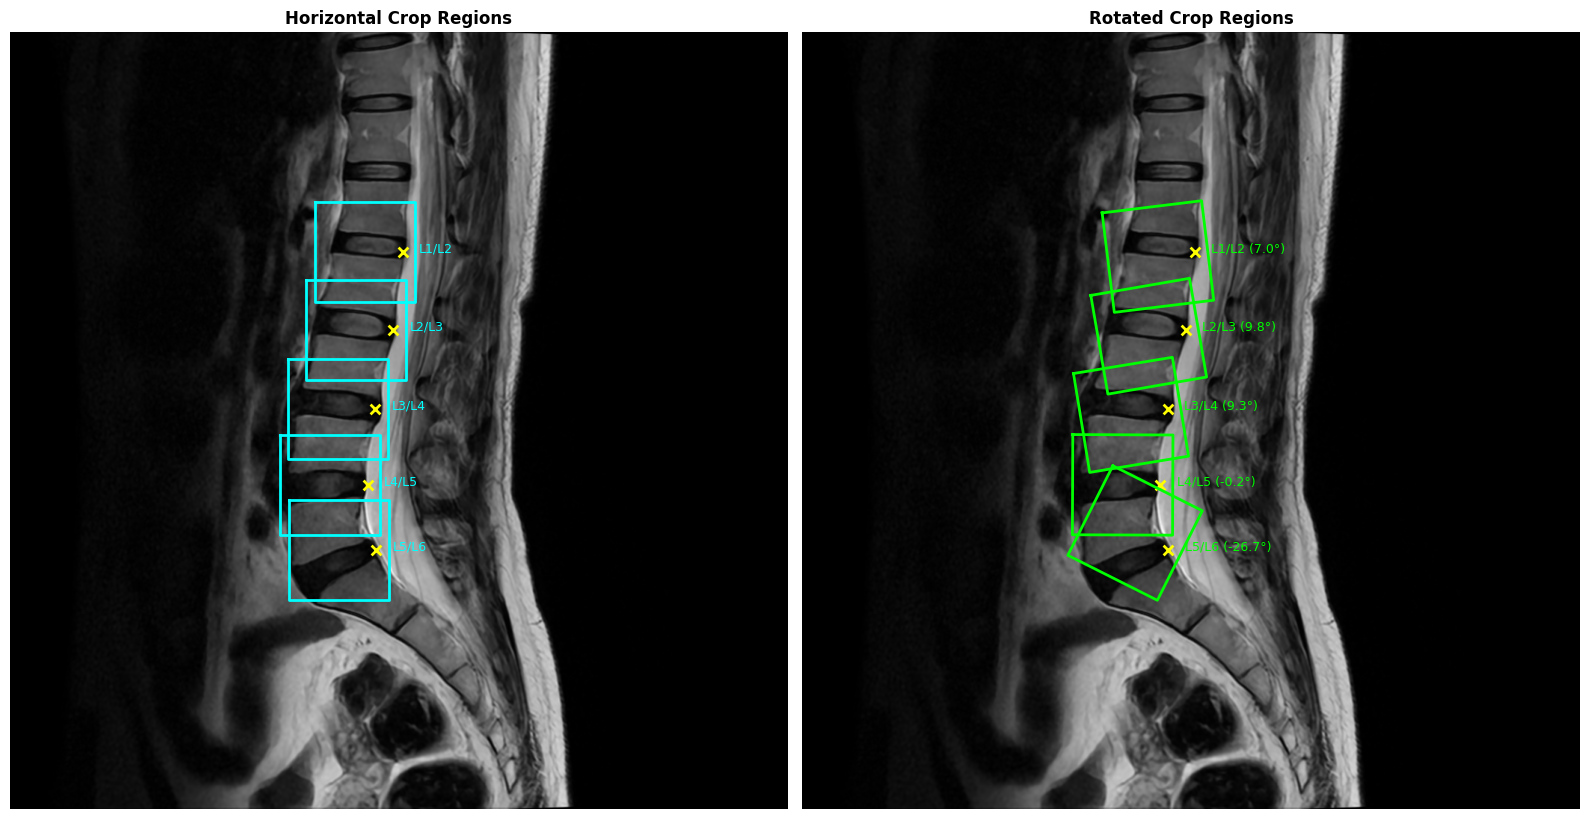

In [12]:
# Show crop regions overlaid on original image
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

left, right, top, bottom = crop_delta_px

# Horizontal mode visualization
ax = axes[0]
ax.imshow(normalize_to_uint8(middle_slice), cmap='gray')
ax.set_title('Horizontal Crop Regions', fontsize=12, fontweight='bold')

for level_idx, (norm_x, norm_y) in ivd_locations.items():
    cx, cy = norm_x * w, norm_y * h
    
    # Draw axis-aligned rectangle (angle=0)
    draw_crop_region(ax, (cx, cy), crop_delta_px, angle=0, color='cyan', linewidth=2)
    ax.scatter([cx], [cy], c='yellow', s=50, marker='x', linewidth=2)
    ax.annotate(f'L{level_idx+1}/L{level_idx+2}', (cx + right + 5, cy), color='cyan', fontsize=9)

ax.axis('off')

# Rotated mode visualization
ax = axes[1]
ax.imshow(normalize_to_uint8(middle_slice), cmap='gray')
ax.set_title('Rotated Crop Regions', fontsize=12, fontweight='bold')

# Use rotation angles from the context (computed with boost)
rotated_angles = ctx_rotated.rotation_angles or {}

for level_idx, (norm_x, norm_y) in ivd_locations.items():
    cx, cy = norm_x * w, norm_y * h
    angle = rotated_angles.get(level_idx, 0)
    
    # Draw rotated rectangle matching actual crop region
    draw_crop_region(ax, (cx, cy), crop_delta_px, angle=angle, color='lime', linewidth=2)
    ax.scatter([cx], [cy], c='yellow', s=50, marker='x', linewidth=2)
    ax.annotate(f'L{level_idx+1}/L{level_idx+2} ({angle:.1f}°)', (cx + right + 5, cy), color='lime', fontsize=9)

ax.axis('off')

plt.tight_layout()
plt.show()

## Test with Multiple Images

In [13]:
# Test with multiple images from the dataset
DATA_DIR = Path.cwd().parent / "data/interim/Phenikaa/images"
OUTPUT_DIR = Path.cwd() / "output/crop"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Get first 5 patient folders
patient_folders = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])[:5]
print(f"Testing with {len(patient_folders)} patients")

Testing with 5 patients


In [14]:
for patient_folder in patient_folders:
    patient_id = patient_folder.name
    series_path = patient_folder / "SAG T2"
    
    if not series_path.exists():
        print(f"Skipping {patient_id}: no SAG T2 series")
        continue
    
    try:
        # Load and process image
        image = read_medical_image(series_path)
        image = resample_to_isotropic(image, new_spacing=(0.3, 0.3, 0.3))
        middle_slice = extract_middle_slice(image)
        spacing_2d = get_slice_spacing(image)
        
        # Predict locations
        ivd_locations = predict_ivd_locations(model, middle_slice, device=DEVICE, image_size=IMAGE_SIZE)
        crop_delta_px = mm_to_pixels(CROP_DELTA_MM, spacing_2d)
        
        # Create contexts
        ctx_h = CropContext(
            image=middle_slice, ivd_locations=ivd_locations,
            crop_size=CROP_SIZE, crop_delta_px=crop_delta_px, mode="horizontal"
        )
        ctx_r = CropContext(
            image=middle_slice, ivd_locations=ivd_locations,
            crop_size=CROP_SIZE, crop_delta_px=crop_delta_px, mode="rotated",
            last_disc_angle_boost=2.0,
        )
        
        # Get rotation angles from context
        angles = ctx_r.rotation_angles or {}
        
        # Create comparison figure
        fig, axes = plt.subplots(5, 2, figsize=(6, 15))
        fig.suptitle(f'Patient: {patient_id}\nHorizontal vs Rotated', fontsize=12, fontweight='bold')
        
        for level_idx in range(5):
            crop_h = ctx_h.crop(level_idx)
            crop_r = ctx_r.crop(level_idx)
            angle = angles.get(level_idx, 0)
            
            axes[level_idx, 0].imshow(crop_h, cmap='gray') if crop_h is not None else None
            axes[level_idx, 0].set_title(f'L{level_idx+1}/L{level_idx+2} (0°)')
            axes[level_idx, 0].axis('off')
            
            axes[level_idx, 1].imshow(crop_r, cmap='gray') if crop_r is not None else None
            axes[level_idx, 1].set_title(f'Rotated ({angle:.1f}°)')
            axes[level_idx, 1].axis('off')
        
        plt.tight_layout()
        output_path = OUTPUT_DIR / f"{patient_id}_comparison.png"
        fig.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close(fig)
        
        print(f"Saved: {output_path.name}")
        
    except Exception as e:
        print(f"Error processing {patient_id}: {e}")

Saved: 250002076_comparison.png
Saved: 250002255_comparison.png
Skipping 250005145: no SAG T2 series
Saved: 250005480_comparison.png
Skipping 250005823: no SAG T2 series
